# Text Conditioning with CLIP and Cross-Attention

In the previous notebook, we controlled generation with **discrete class labels** (0-9 for digits). This required a fixed vocabulary and a simple embedding table. Now we move to **natural language conditioning** - the ability to say "a photo of a cat" and generate a cat.

This is how modern text-to-image models like Stable Diffusion, DALL-E, and Midjourney work.

## The Evolution of Conditioning

| Notebook | Conditioning | Example | Mechanism |
|----------|-------------|---------|------------|
| Flow Matching, DiT | None | Generate any image | - |
| Class Conditioning | Class label | "Generate digit 7" | $c = h_t + e(y)$ |
| **This Notebook** | Text prompt | "a photo of a cat" | Cross-attention to CLIP |

## The Mathematical Challenge

We need to learn a text-conditional velocity field:

$$v_\theta(x_t, t, \text{text}) : \mathbb{R}^{C \times H \times W} \times [0,1] \times \text{String} \to \mathbb{R}^{C \times H \times W}$$

But "String" isn't a mathematical object. We need to convert text to vectors.

## Why Cross-Attention?

In the previous notebook, we simply added the class embedding to the timestep embedding:

$$c = h_t + e(y) \in \mathbb{R}^D$$

This works for **single tokens** (class labels), but text has **multiple tokens**. We need a mechanism that:

1. Handles variable-length sequences
2. Allows different image regions to focus on different words
3. Preserves the full information in each token

**Cross-attention** provides all of this.

## What We'll Learn

1. **CLIP Text Encoder** - How text becomes vectors
2. **Cross-Attention** - How image patches attend to text tokens
3. **Text-Conditional DiT** - The full architecture
4. **CFG for Text** - Classifier-free guidance with prompts

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

from from_noise_to_images import get_device
device = get_device()
print(f"Using device: {device}")

Using device: cuda


## Step 1: CLIP - The Bridge Between Text and Images

CLIP (Contrastive Language-Image Pre-training) is a model trained on 400M image-text pairs to learn a shared embedding space.

### The CLIP Training Objective

Given a batch of $N$ image-text pairs, CLIP learns to:

1. **Maximize** similarity between matching pairs
2. **Minimize** similarity between non-matching pairs

$$\mathcal{L}_{\text{CLIP}} = -\frac{1}{N}\sum_{i=1}^N \log \frac{\exp(\text{sim}(I_i, T_i)/\tau)}{\sum_{j=1}^N \exp(\text{sim}(I_i, T_j)/\tau)}$$

This creates **visually grounded** text embeddings:

| Property | Meaning | Example |
|----------|---------|--------|
| **Semantic** | Similar meanings → similar vectors | "dog" ≈ "puppy" |
| **Visual** | Vectors encode visual features | "red" encodes color |
| **Compositional** | Combinations work | "blue dog" is meaningful |

### CLIP Text Encoder Architecture

```
Text: "a photo of a cat"
         │
         ▼
    ┌─────────┐
    │ Tokenize│  → ["a", "photo", "of", "a", "cat"]
    └────┬────┘
         │
         ▼
    ┌─────────┐
    │  Embed  │  → [e₁, e₂, e₃, e₄, e₅]
    └────┬────┘
         │
         ▼
    ┌─────────────┐
    │ Transformer │  → 12 layers of self-attention
    └──────┬──────┘
           │
           ▼
    Token Embeddings: Z ∈ R^{M × D}
```

We use the **token embeddings** (not just the pooled output) for cross-attention.

In [2]:
from from_noise_to_images.text_encoder import CLIPTextEncoder

# Load CLIP text encoder
text_encoder = CLIPTextEncoder(
    model_name="openai/clip-vit-base-patch32",
    device=device,
)

print(f"CLIP embedding dimension: {text_encoder.embed_dim}")
print(f"Max sequence length: {text_encoder.max_length}")

CLIP embedding dimension: 512
Max sequence length: 77


Token embeddings shape: torch.Size([5, 77, 512])
  → (batch_size, max_length, embed_dim)
Pooled embeddings shape: torch.Size([5, 512])
  → (batch_size, embed_dim)


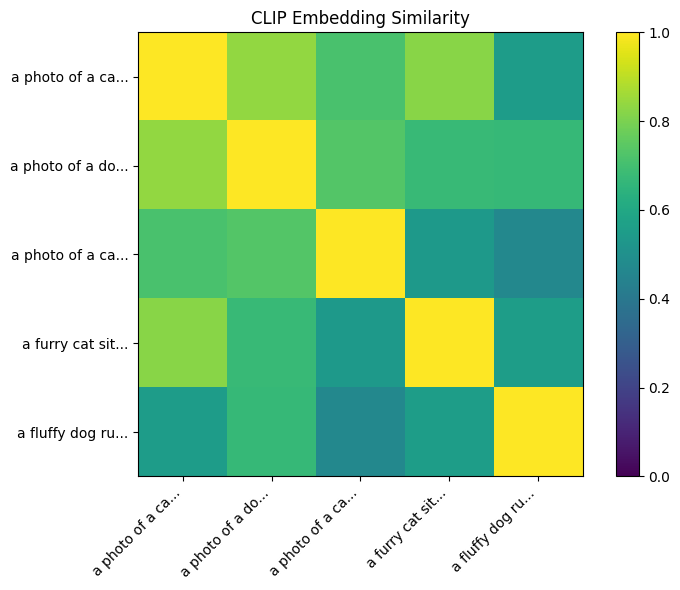


Key Observations:
  - 'cat' prompts are similar to each other
  - 'dog' prompts are similar to each other
  - Both are less similar to 'car'


In [3]:
# Explore CLIP embeddings
prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a furry cat sitting",
    "a fluffy dog running",
]

# Get token embeddings and pooled embeddings
token_embeddings, pooled = text_encoder.encode(prompts, return_pooled=True)

print(f"Token embeddings shape: {token_embeddings.shape}")
print(f"  → (batch_size, max_length, embed_dim)")
print(f"Pooled embeddings shape: {pooled.shape}")
print(f"  → (batch_size, embed_dim)")

# Compute similarity matrix from pooled embeddings
pooled_norm = pooled / pooled.norm(dim=-1, keepdim=True)
similarity = (pooled_norm @ pooled_norm.T).cpu().numpy()

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(similarity, cmap='viridis', vmin=0, vmax=1)
ax.set_xticks(range(len(prompts)))
ax.set_yticks(range(len(prompts)))
ax.set_xticklabels([p[:15] + "..." for p in prompts], rotation=45, ha='right')
ax.set_yticklabels([p[:15] + "..." for p in prompts])
ax.set_title('CLIP Embedding Similarity')
plt.colorbar(im)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - 'cat' prompts are similar to each other")
print("  - 'dog' prompts are similar to each other")
print("  - Both are less similar to 'car'")

## Step 2: Cross-Attention - Image Patches Attending to Text

Cross-attention allows each image patch to "look at" the text and extract relevant information.

### Mathematical Formulation

Given:
- Image patch embeddings: $X \in \mathbb{R}^{N \times d}$ (N patches)
- Text token embeddings: $Z \in \mathbb{R}^{M \times D}$ (M tokens)

Cross-attention computes:

$$\text{CrossAttn}(X, Z) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) V$$

where:
- $Q = X W_Q \in \mathbb{R}^{N \times d_k}$ — **Queries** from image patches
- $K = Z W_K \in \mathbb{R}^{M \times d_k}$ — **Keys** from text tokens
- $V = Z W_V \in \mathbb{R}^{M \times d_v}$ — **Values** from text tokens

### The Attention Matrix

$$A = \text{softmax}\left(\frac{Q K^T}{\sqrt{d_k}}\right) \in \mathbb{R}^{N \times M}$$

Entry $A_{ij}$ represents: "How much should image patch $i$ attend to text token $j$?"

### Intuitive Understanding

For the prompt "a RED dog RUNNING":

```
                    Text Tokens
                 a   RED  dog  RUNNING
              ┌────────────────────────┐
    Patch 1   │ 0.1  0.7  0.1   0.1    │  ← Color region, attends to "RED"
    Patch 2   │ 0.1  0.1  0.6   0.2    │  ← Body region, attends to "dog"
    Patch 3   │ 0.1  0.1  0.3   0.5    │  ← Leg region, attends to "RUNNING"
    Patch 4   │ 0.2  0.3  0.3   0.2    │  ← Background, mixed attention
              └────────────────────────┘
```

### Self-Attention vs Cross-Attention

| Aspect | Self-Attention | Cross-Attention |
|--------|----------------|------------------|
| Q, K, V source | Same sequence (X) | Q from X, K/V from Z |
| Attention shape | $N \times N$ | $N \times M$ |
| Purpose | Patch-to-patch relations | Text-to-image transfer |
| Information flow | Within image | From text to image |

In [4]:
from from_noise_to_images.dit import CrossAttention

# Create a cross-attention layer
embed_dim = 256   # Image patch embedding dimension
context_dim = 512  # CLIP text embedding dimension
num_heads = 8

cross_attn = CrossAttention(
    embed_dim=embed_dim,
    context_dim=context_dim,
    num_heads=num_heads,
).to(device)

# Simulate inputs
batch_size = 2
num_patches = 64  # 8x8 grid
num_tokens = 10   # Text sequence length

# Random image patch embeddings
x = torch.randn(batch_size, num_patches, embed_dim, device=device)

# Random text embeddings (simulating CLIP output)
context = torch.randn(batch_size, num_tokens, context_dim, device=device)

# Forward pass
with torch.no_grad():
    output = cross_attn(x, context)

print(f"Cross-Attention Dimensions:")
print(f"  Image patches (X): {x.shape}")
print(f"  Text tokens (Z):   {context.shape}")
print(f"  Output:            {output.shape}")
print(f"\nThe output has the same shape as the image patches!")
print(f"Each patch now contains information from relevant text tokens.")

Cross-Attention Dimensions:
  Image patches (X): torch.Size([2, 64, 256])
  Text tokens (Z):   torch.Size([2, 10, 512])
  Output:            torch.Size([2, 64, 256])

The output has the same shape as the image patches!
Each patch now contains information from relevant text tokens.


Prompt: 'a red car driving fast'
Tokens: ['[BOS]', 'a</w>', 'red</w>', 'car</w>', 'driving</w>', 'fast</w>', '[EOS]']



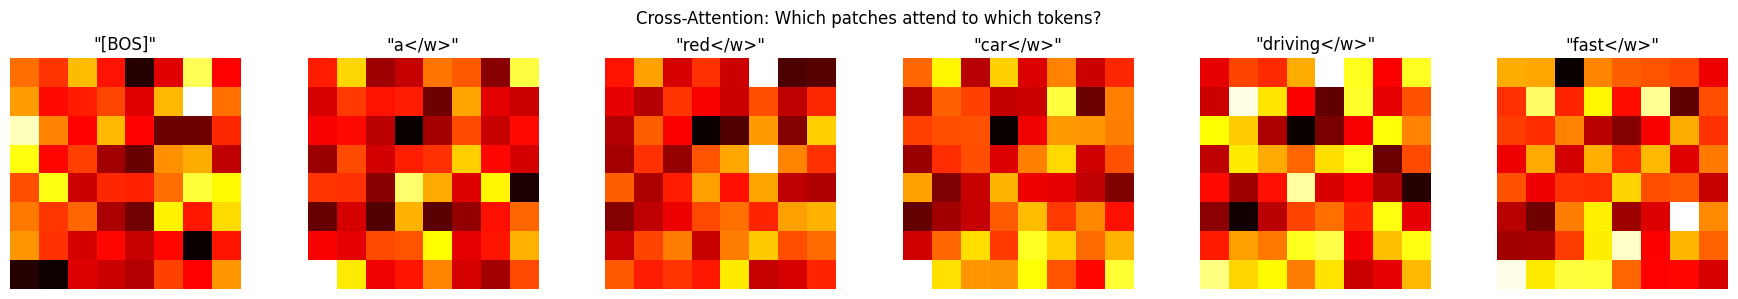

In [5]:
# Visualize attention weights for a real prompt
def visualize_cross_attention_weights(
    cross_attn: CrossAttention,
    x: torch.Tensor,
    context: torch.Tensor,
    tokens: list,
):
    """Visualize what each image patch attends to in the text."""
    B, N, _ = x.shape
    M = context.shape[1]
    H = cross_attn.num_heads
    d = cross_attn.head_dim
    
    with torch.no_grad():
        # Compute Q, K
        q = cross_attn.q_proj(x)
        k = cross_attn.k_proj(context)
        
        # Reshape for attention
        q = q.view(B, N, H, d).transpose(1, 2)
        k = k.view(B, M, H, d).transpose(1, 2)
        
        # Compute attention scores
        attn = (q @ k.transpose(-2, -1)) * cross_attn.scale
        attn = attn.softmax(dim=-1)  # (B, H, N, M)
    
    # Average over heads and batch
    attn_avg = attn[0].mean(dim=0).cpu().numpy()  # (N, M)
    
    # Reshape to 2D grid (assuming square patches)
    grid_size = int(np.sqrt(N))
    
    # Plot attention for each token
    num_tokens_to_show = min(6, M)
    fig, axes = plt.subplots(1, num_tokens_to_show, figsize=(3*num_tokens_to_show, 3))
    
    for i in range(num_tokens_to_show):
        attn_map = attn_avg[:, i].reshape(grid_size, grid_size)
        axes[i].imshow(attn_map, cmap='hot')
        token = tokens[i] if i < len(tokens) else "[PAD]"
        axes[i].set_title(f'"{token}"')
        axes[i].axis('off')
    
    plt.suptitle('Cross-Attention: Which patches attend to which tokens?', fontsize=12)
    plt.tight_layout()
    plt.show()

# Get real CLIP embeddings
test_prompt = "a red car driving fast"
test_embeddings, test_mask = text_encoder(test_prompt)
test_embeddings = test_embeddings.to(device)

# Get tokens for visualization
tokens = text_encoder.tokenizer.tokenize(test_prompt)
tokens = ['[BOS]'] + tokens + ['[EOS]']

# Random image patches (in practice, these would be from the DiT)
num_patches = 64
x_test = torch.randn(1, num_patches, embed_dim, device=device)

print(f"Prompt: '{test_prompt}'")
print(f"Tokens: {tokens}")
print()

visualize_cross_attention_weights(cross_attn, x_test, test_embeddings, tokens)

## Step 3: Text-Conditional DiT Architecture

The TextConditionalDiT extends our DiT with cross-attention layers.

### Block Structure

Each TextConditionedDiTBlock has three components:

```
                                        Text Embeddings Z
                                              │
                                              ▼
x ─► adaLN ─► Self-Attn ─► + ─► adaLN ─► Cross-Attn ─► + ─► adaLN ─► MLP ─► + ─► out
│                         │   │                        │   │                │
└───────(residual)────────┘   └───────(residual)───────┘   └──(residual)────┘
```

### Mathematical Formulation

Let $x^{(l)}$ be the input to layer $l$, $c$ be timestep conditioning, $Z$ be text embeddings:

$$x^{(l+1/3)} = x^{(l)} + \text{SelfAttn}(\text{adaLN}(x^{(l)}, c))$$
$$x^{(l+2/3)} = x^{(l+1/3)} + \text{CrossAttn}(\text{adaLN}(x^{(l+1/3)}, c), Z)$$
$$x^{(l+1)} = x^{(l+2/3)} + \text{MLP}(\text{adaLN}(x^{(l+2/3)}, c))$$

### Full Architecture

```
Text Prompt                    Noisy Image x_t          Timestep t
     │                              │                       │
     ▼                              ▼                       ▼
┌─────────┐                  ┌───────────┐           ┌───────────┐
│  CLIP   │                  │ Patchify  │           │ Time Emb  │
│ Encoder │                  │ + PosEmb  │           │   (MLP)   │
└────┬────┘                  └─────┬─────┘           └─────┬─────┘
     │                             │                       │
     │ Z ∈ R^{M × D}               │ X ∈ R^{N × d}         │ c ∈ R^{d_c}
     │                             │                       │
     │                             ▼                       │
     │                    ┌─────────────────┐              │
     └───────────────────►│ TextConditioned │◄─────────────┘
                          │    DiT Blocks   │
                          └────────┬────────┘
                                   │
                                   ▼
                          ┌─────────────────┐
                          │   Unpatchify    │
                          └────────┬────────┘
                                   │
                                   ▼
                          Velocity v ∈ R^{C × H × W}
```

### Key Differences from ConditionalDiT

| Aspect | ConditionalDiT | TextConditionalDiT |
|--------|----------------|---------------------|
| Conditioning | Class labels (0-9) | Text prompts |
| Embedding | Learnable table | Frozen CLIP |
| Integration | Added to timestep | Cross-attention |
| Vocabulary | Fixed (10 classes) | Open (any text) |
| Representation | Single vector | Sequence of tokens |

In [6]:
from from_noise_to_images.dit import TextConditionalDiT

# Create the text-conditional DiT for CIFAR-10 (32x32 RGB)
model = TextConditionalDiT(
    img_size=32,          # CIFAR-10 image size
    patch_size=4,         # 4x4 patches → 8x8 = 64 patches
    in_channels=3,        # RGB
    embed_dim=256,        # Patch embedding dimension
    depth=6,              # Number of transformer blocks
    num_heads=8,          # Attention heads
    mlp_ratio=4.0,        # MLP expansion
    context_dim=512,      # CLIP ViT-B/32 embedding dimension
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"TextConditionalDiT Parameters: {num_params:,}")

# Compare to ConditionalDiT
from from_noise_to_images.dit import ConditionalDiT
class_model = ConditionalDiT(img_size=32, patch_size=4, in_channels=3)
class_params = sum(p.numel() for p in class_model.parameters() if p.requires_grad)
print(f"ConditionalDiT Parameters: {class_params:,}")
print(f"Difference: +{num_params - class_params:,} (cross-attention layers)")

TextConditionalDiT Parameters: 18,145,072
ConditionalDiT Parameters: 12,379,440
Difference: +5,765,632 (cross-attention layers)


In [7]:
# Test forward pass
batch_size = 4

# Random noisy images
x = torch.randn(batch_size, 3, 32, 32, device=device)

# Random timesteps
t = torch.rand(batch_size, device=device)

# Text embeddings from CLIP
prompts = [
    "a photo of a cat",
    "a photo of a dog",
    "a photo of a car",
    "a photo of a plane",
]
text_embeddings, text_mask = text_encoder(prompts)
text_embeddings = text_embeddings.to(device)
text_mask = text_mask.to(device)

# Forward pass
with torch.no_grad():
    v_pred = model(x, t, text_embeddings, text_mask)

print(f"Input shape:       {x.shape}")
print(f"Timesteps shape:   {t.shape}")
print(f"Text embed shape:  {text_embeddings.shape}")
print(f"Text mask shape:   {text_mask.shape}")
print(f"Output shape:      {v_pred.shape}")
print(f"\nModel correctly outputs velocity field with same shape as input!")

Input shape:       torch.Size([4, 3, 32, 32])
Timesteps shape:   torch.Size([4])
Text embed shape:  torch.Size([4, 77, 512])
Text mask shape:   torch.Size([4, 77])
Output shape:      torch.Size([4, 3, 32, 32])

Model correctly outputs velocity field with same shape as input!


## Step 4: Dataset - CIFAR-10 with Text Captions

We'll use CIFAR-10 (32×32 RGB images) with class names converted to captions.

### CIFAR-10 Classes → Captions

| Index | Class | Caption Template |
|-------|-------|------------------|
| 0 | airplane | "a photo of an airplane" |
| 1 | automobile | "a photo of an automobile" |
| 2 | bird | "a photo of a bird" |
| 3 | cat | "a photo of a cat" |
| 4 | deer | "a photo of a deer" |
| 5 | dog | "a photo of a dog" |
| 6 | frog | "a photo of a frog" |
| 7 | horse | "a photo of a horse" |
| 8 | ship | "a photo of a ship" |
| 9 | truck | "a photo of a truck" |

CLIP understands "a photo of a X" format very well from its training.

In [8]:
from from_noise_to_images.text_encoder import make_cifar10_captions

# Load CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0,
    drop_last=True
)

# Test caption function
sample_labels = torch.tensor([0, 3, 5, 8])
captions = make_cifar10_captions(sample_labels)

print("Label → Caption mapping:")
for label, caption in zip(sample_labels.tolist(), captions):
    print(f"  {label} → '{caption}'")

Label → Caption mapping:
  0 → 'a photo of an airplane'
  3 → 'a photo of a cat'
  5 → 'a photo of a dog'
  8 → 'a photo of a ship'


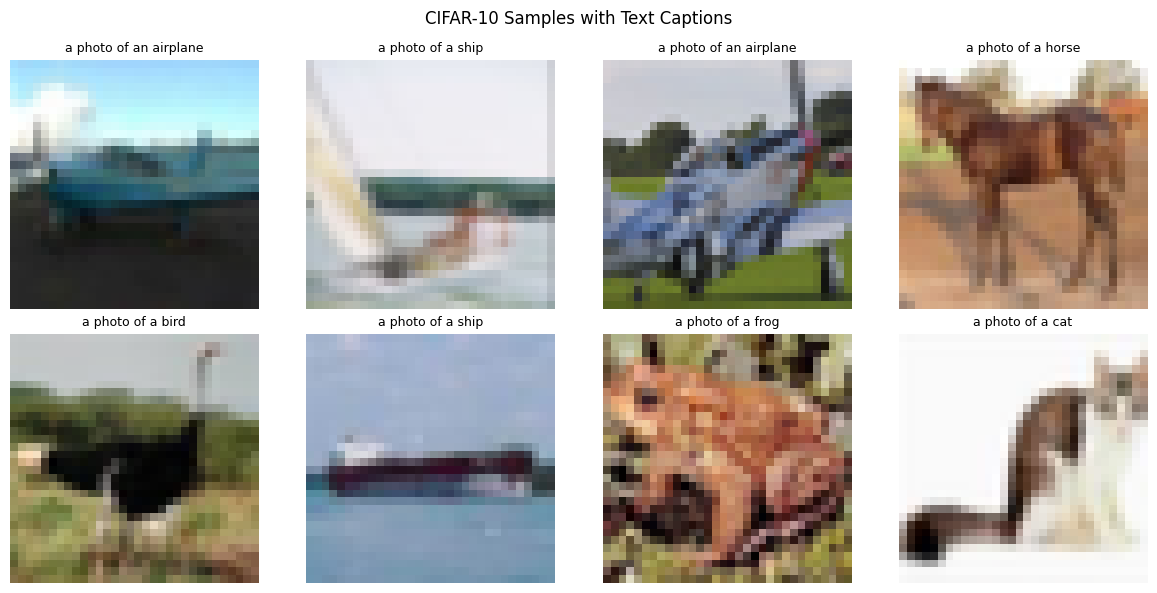

In [9]:
# Visualize samples with their captions
images, labels = next(iter(train_loader))
captions = make_cifar10_captions(labels[:8])

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, (ax, img, caption) in enumerate(zip(axes.flat, images[:8], captions)):
    # Denormalize
    img = (img + 1) / 2
    img = img.permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(caption, fontsize=9)
    ax.axis('off')

plt.suptitle('CIFAR-10 Samples with Text Captions', fontsize=12)
plt.tight_layout()
plt.show()

## Step 5: Classifier-Free Guidance for Text

CFG works the same way as before, but with text embeddings.

### The CFG Formula (Same as Before)

$$v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$$

where:
- $v_{\text{cond}} = v_\theta(x_t, t, Z_{\text{text}})$ — Velocity with text embedding
- $v_{\text{uncond}} = v_\theta(x_t, t, Z_{\text{null}})$ — Velocity with null text
- $w$ — Guidance scale

### What is Null Text?

The "null text" is an empty string encoded by CLIP:

$$Z_{\text{null}} = \text{CLIP}("") \in \mathbb{R}^{M \times D}$$

This represents "no specific content" - similar to the null class in the previous notebook.

### Text Dropout During Training

To enable CFG, we randomly replace text embeddings with null:

$$Z_{\text{train}} = \begin{cases}
\text{CLIP}(\text{prompt}) & \text{w.p. } 1 - p_{\text{drop}} \\
\text{CLIP}("") & \text{w.p. } p_{\text{drop}}
\end{cases}$$

Typically $p_{\text{drop}} = 0.1$ (10%).

### Guidance Scale: Text vs Class

| Conditioning | Typical Scale | Reason |
|--------------|---------------|--------|
| Class | 3-5 | Simple, direct mapping |
| Text | 7-10 | Complex, needs stronger push |

Text conditioning is more nuanced - higher guidance pushes toward the most "on-prompt" outputs.

In [10]:
# Compare text embedding vs null embedding
_, text_emb = text_encoder.encode(["a photo of a cat"], return_pooled=True)
_, null_emb = text_encoder.encode([""], return_pooled=True)

# Compute similarity
text_norm = text_emb / text_emb.norm(dim=-1, keepdim=True)
null_norm = null_emb / null_emb.norm(dim=-1, keepdim=True)
similarity = (text_norm @ null_norm.mT).item()

print(f"Text embedding shape: {text_emb.shape}")
print(f"Null embedding shape: {null_emb.shape}")
print(f"Cosine similarity: {similarity:.3f}")
print(f"\nThe null embedding is different from any real text embedding.")
print(f"This makes CFG work: we can push away from 'nothing' toward 'something'.")

Text embedding shape: torch.Size([1, 512])
Null embedding shape: torch.Size([1, 512])
Cosine similarity: 0.653

The null embedding is different from any real text embedding.
This makes CFG work: we can push away from 'nothing' toward 'something'.


## Step 6: Training the Text-Conditional DiT

Training follows the same flow matching objective, now with text conditioning.

### Training Algorithm

For each batch of (image, label) pairs:

1. **Convert labels to captions**: $y \to \text{"a photo of a "} + \text{class\_name}$
2. **Encode with CLIP**: $\text{caption} \to Z \in \mathbb{R}^{M \times D}$
3. **Apply text dropout**: With 10% probability, $Z \leftarrow Z_{\text{null}}$
4. **Sample noise and time**: $x_1 \sim \mathcal{N}(0, I)$, $t \sim \text{Uniform}(0, 1)$
5. **Interpolate**: $x_t = (1-t) x_0 + t x_1$
6. **Predict velocity**: $\hat{v} = v_\theta(x_t, t, Z)$
7. **Compute loss**: $\mathcal{L} = \|\hat{v} - (x_1 - x_0)\|^2$

### Loss Function

$$\mathcal{L} = \mathbb{E}_{x_0, x_1, t, Z}\left[ \| v_\theta(x_t, t, Z) - (x_1 - x_0) \|^2 \right]$$

In [11]:
from from_noise_to_images.train import TextConditionalTrainer

# Create the trainer
trainer = TextConditionalTrainer(
    model=model,
    text_encoder=text_encoder,
    dataloader=train_loader,
    caption_fn=make_cifar10_captions,
    lr=1e-4,
    weight_decay=0.01,
    text_drop_prob=0.1,  # 10% text dropout for CFG
    device=device,
)

print("Training Text-Conditional DiT with CFG text dropout...")
print("(10% of samples trained with null text)\n")

NUM_EPOCHS = 30
losses = trainer.train(num_epochs=NUM_EPOCHS)

Training Text-Conditional DiT with CFG text dropout...
(10% of samples trained with null text)

Training on cuda
Model parameters: 18,145,072
CFG text dropout: 10%


Epoch 1/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 1: avg_loss = 0.5415


Epoch 2/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 2: avg_loss = 0.2999


Epoch 3/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 3: avg_loss = 0.2795


Epoch 4/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 4: avg_loss = 0.2669


Epoch 5/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 5: avg_loss = 0.2573


Epoch 6/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 6: avg_loss = 0.2499


Epoch 7/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 7: avg_loss = 0.2462


Epoch 8/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 8: avg_loss = 0.2407


Epoch 9/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 9: avg_loss = 0.2365


Epoch 10/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 10: avg_loss = 0.2327


Epoch 11/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 11: avg_loss = 0.2304


Epoch 12/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 12: avg_loss = 0.2280


Epoch 13/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 13: avg_loss = 0.2229


Epoch 14/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 14: avg_loss = 0.2223


Epoch 15/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 15: avg_loss = 0.2183


Epoch 16/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 16: avg_loss = 0.2167


Epoch 17/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 17: avg_loss = 0.2150


Epoch 18/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 18: avg_loss = 0.2124


Epoch 19/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 19: avg_loss = 0.2100


Epoch 20/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 20: avg_loss = 0.2079


Epoch 21/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 21: avg_loss = 0.2069


Epoch 22/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 22: avg_loss = 0.2057


Epoch 23/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 23: avg_loss = 0.2040


Epoch 24/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 24: avg_loss = 0.2034


Epoch 25/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 25: avg_loss = 0.2029


Epoch 26/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 26: avg_loss = 0.2017


Epoch 27/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 27: avg_loss = 0.2009


Epoch 28/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 28: avg_loss = 0.2005


Epoch 29/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 29: avg_loss = 0.1996


Epoch 30/30:   0%|          | 0/781 [00:00<?, ?it/s]

Epoch 30: avg_loss = 0.1997


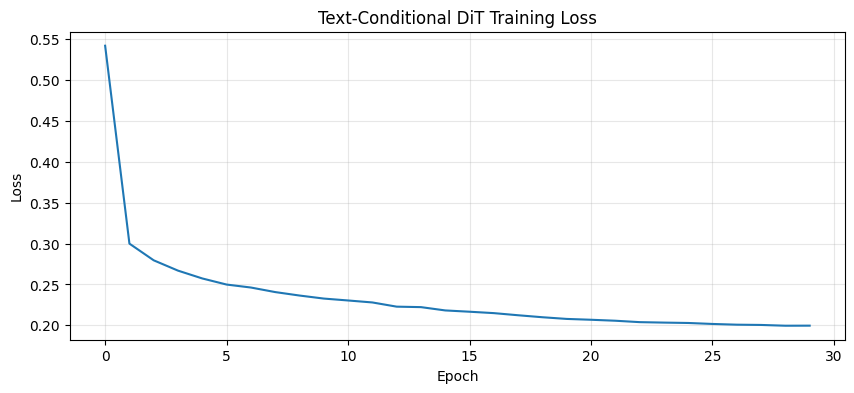

Final loss: 0.1997


In [12]:
# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Text-Conditional DiT Training Loss')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final loss: {losses[-1]:.4f}")

## Step 7: Sampling with Text Prompts

Now the exciting part - generating images from text!

### CFG Sampling Algorithm

```
Input: Trained model v_θ, text prompt, guidance scale w, num_steps N

1. Encode text: Z_text = CLIP(prompt)
2. Encode null: Z_null = CLIP("")
3. Sample x_1 ~ N(0, I)  # Pure noise
4. dt = 1/N

For t = 1, 1-dt, ..., dt:
    v_cond = v_θ(x_t, t, Z_text)    # With text
    v_uncond = v_θ(x_t, t, Z_null)  # Without text
    v_guided = v_uncond + w × (v_cond - v_uncond)  # CFG
    x_t ← x_t - dt × v_guided       # Euler step

Return x_0  # Generated image
```

Generating images for each class with CFG scale=7.5...


Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

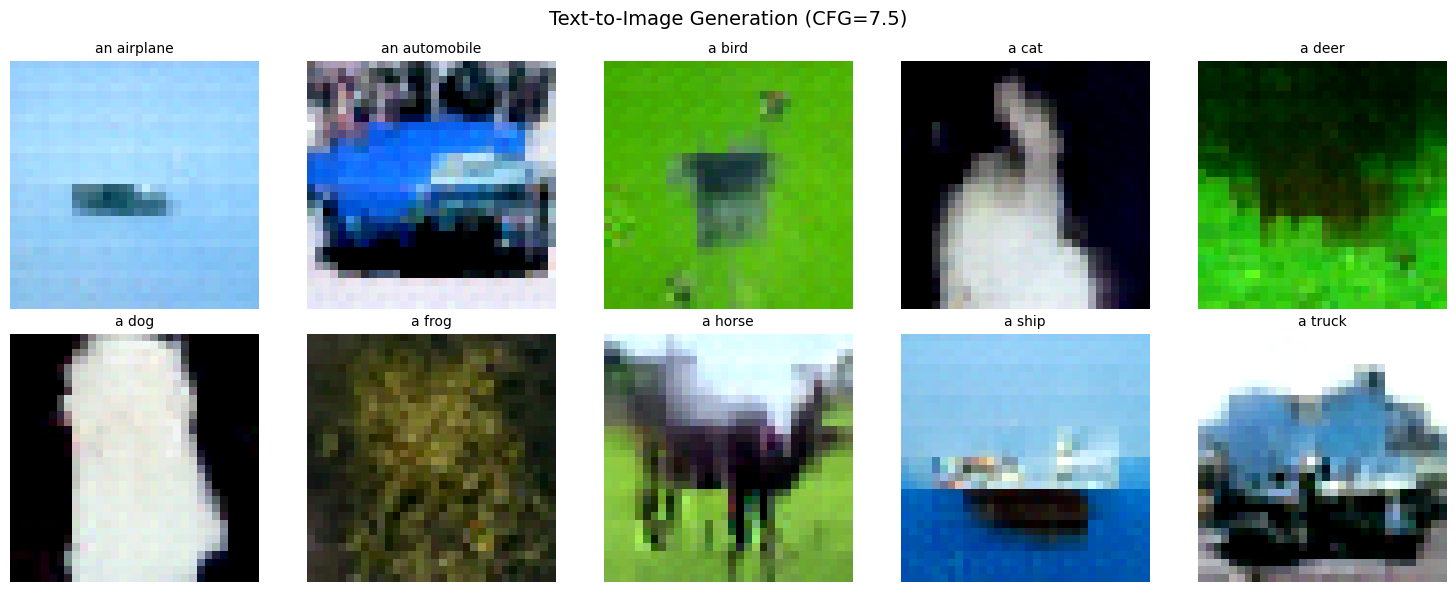

In [13]:
from from_noise_to_images.sampling import sample_text_conditional

model.eval()

# Generate images for each CIFAR-10 class
prompts = [
    "a photo of an airplane",
    "a photo of an automobile",
    "a photo of a bird",
    "a photo of a cat",
    "a photo of a deer",
    "a photo of a dog",
    "a photo of a frog",
    "a photo of a horse",
    "a photo of a ship",
    "a photo of a truck",
]

print("Generating images for each class with CFG scale=7.5...")

samples = sample_text_conditional(
    model=model,
    text_encoder=text_encoder,
    prompts=prompts,
    image_shape=(3, 32, 32),
    num_steps=50,
    cfg_scale=7.5,
    device=device,
)

# Display results
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (ax, prompt) in enumerate(zip(axes.flat, prompts)):
    img = (samples[i] + 1) / 2  # Denormalize
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(prompt.replace('a photo of ', ''), fontsize=10)
    ax.axis('off')

plt.suptitle('Text-to-Image Generation (CFG=7.5)', fontsize=14)
plt.tight_layout()
plt.show()

Comparing CFG scales for: 'a photo of a cat'


Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

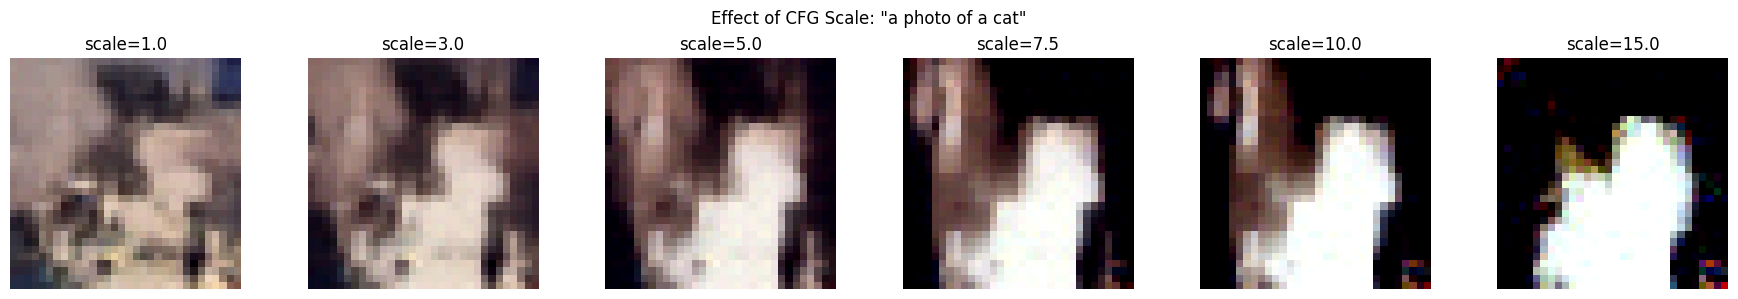


Observations:
  scale=1.0: No guidance, blurry
  scale=3-5: Mild guidance, improving
  scale=7-10: Good balance
  scale=15+: May oversaturate


In [14]:
# Compare different CFG scales
test_prompt = "a photo of a cat"
cfg_scales = [1.0, 3.0, 5.0, 7.5, 10.0, 15.0]

print(f"Comparing CFG scales for: '{test_prompt}'")

fig, axes = plt.subplots(1, len(cfg_scales), figsize=(18, 3))

for ax, scale in zip(axes, cfg_scales):
    # Use same seed for fair comparison
    torch.manual_seed(42)
    
    sample = sample_text_conditional(
        model=model,
        text_encoder=text_encoder,
        prompts=[test_prompt],
        image_shape=(3, 32, 32),
        num_steps=50,
        cfg_scale=scale,
        device=device,
    )
    
    img = (sample[0] + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(f'scale={scale}')
    ax.axis('off')

plt.suptitle(f'Effect of CFG Scale: "{test_prompt}"', fontsize=12)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("  scale=1.0: No guidance, blurry")
print("  scale=3-5: Mild guidance, improving")
print("  scale=7-10: Good balance")
print("  scale=15+: May oversaturate")

Testing compositional understanding...
(Results may be limited by CIFAR-10 training data)



Sampling (Text CFG):   0%|          | 0/50 [00:00<?, ?it/s]

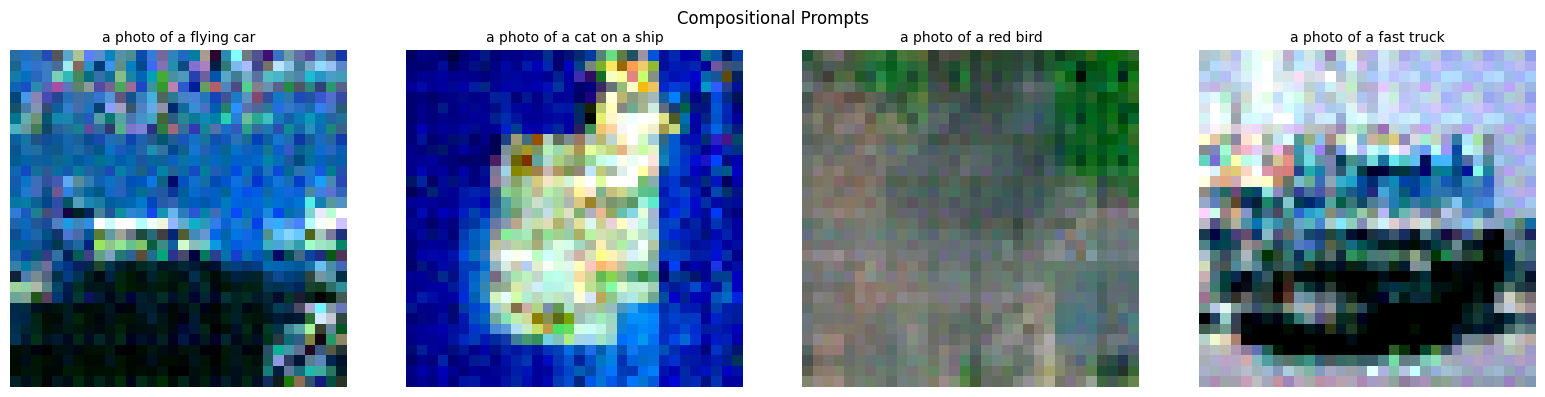

In [15]:
# Try some creative prompts
creative_prompts = [
    "a photo of a flying car",
    "a photo of a cat on a ship",
    "a photo of a red bird",
    "a photo of a fast truck",
]

print("Testing compositional understanding...")
print("(Results may be limited by CIFAR-10 training data)\n")

torch.manual_seed(123)
creative_samples = sample_text_conditional(
    model=model,
    text_encoder=text_encoder,
    prompts=creative_prompts,
    image_shape=(3, 32, 32),
    num_steps=50,
    cfg_scale=7.5,
    device=device,
)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for ax, prompt, sample in zip(axes, creative_prompts, creative_samples):
    img = (sample + 1) / 2
    img = img.permute(1, 2, 0).cpu().numpy()
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(prompt, fontsize=10)
    ax.axis('off')

plt.suptitle('Compositional Prompts', fontsize=12)
plt.tight_layout()
plt.show()

In [16]:
# Save the trained model
trainer.save_checkpoint("phase4_text_conditional_dit.pt")
print("Model saved to phase4_text_conditional_dit.pt")

Model saved to phase4_text_conditional_dit.pt


## Summary: Text-to-Image Generation

We extended the DiT to accept natural language prompts via CLIP and cross-attention.

### Key Equations

| Concept | Equation |
|---------|----------|
| CLIP encoding | $Z = \text{CLIP}(\text{text}) \in \mathbb{R}^{M \times D}$ |
| Cross-attention | $\text{CrossAttn}(X, Z) = \text{softmax}\left(\frac{Q K^T}{\sqrt{d}}\right) V$ |
| Queries | $Q = X W_Q$ (from image patches) |
| Keys, Values | $K = Z W_K$, $V = Z W_V$ (from text tokens) |
| Training loss | $\mathcal{L} = \mathbb{E}[\|v_\theta(x_t, t, Z) - v\|^2]$ |
| CFG formula | $v_{\text{CFG}} = v_{\text{uncond}} + w \cdot (v_{\text{cond}} - v_{\text{uncond}})$ |
| Null text | $Z_{\text{null}} = \text{CLIP}("")$ |

### Cross-Attention Details

The attention matrix $A \in \mathbb{R}^{N \times M}$:
- $N$ = number of image patches
- $M$ = number of text tokens

$$A_{ij} = \frac{\exp(q_i \cdot k_j / \sqrt{d})}{\sum_{j'} \exp(q_i \cdot k_{j'} / \sqrt{d})}$$

$A_{ij}$ answers: "How much should image patch $i$ attend to text token $j$?"

### Architecture Comparison

| Notebook | Model | Conditioning | Mechanism |
|----------|-------|-------------|------------|
| 01-02 | DiT | None | - |
| 03 | ConditionalDiT | Class labels | $c = h_t + e(y)$, adaLN |
| 04 | TextConditionalDiT | Text prompts | Cross-attention to CLIP |

## What's Next

In the next notebook, we add **latent space diffusion** with a VAE:

| Current (Pixel Space) | Next (Latent Space) |
|----------------------|---------------------|
| Diffusion on 32×32×3 | Diffusion on 4×4×4 latent |
| 3,072 dimensions | 64 dimensions (48× smaller) |
| Limited resolution | Scales to 256×256+ |

This is how Stable Diffusion achieves high-resolution generation!